__Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)__<br>
<br>__Домашнее задание:__<br>
1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)<br>

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)<br>

3. Повторить п.2, но используя уже не медиану, а max<br>

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.<br>

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score<br>

6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных<br>

__Ссылки:__<br>
http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf<br>
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation<br>


In [1]:
import numpy as np
import pandas as pd
from gensim.corpora.dictionary import Dictionary
import re
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2
from gensim.models import LdaModel
from gensim.test.utils import datapath
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from itertools import product
from sklearn.pipeline import Pipeline

In [2]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

In [3]:
def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [4]:
#функция, которая возвращает векторное представление новости

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [45]:
def get_user_embedding(user_articles_list, f_metod=np.mean):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = f_metod(user_vector, 0)
    return user_vector

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def calc_metrics(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_test, preds)
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))

### 1. Загрузим новости

In [8]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


### 2. Загрузим пользователей и списки последних прочитанных новостей

In [9]:
users = pd.read_csv("users_articles.csv")
users.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 3. Получаем векторные представления новостей

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/svm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [13]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [14]:
%%time
#Запускаем очистку текста.
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/tmp/ipykernel_3240/1966749074.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 28.8 s, sys: 666 ms, total: 29.5 s
Wall time: 29.5 s


In [15]:
%%time
#Запускаем лемматизацию текста.
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 10s, sys: 171 ms, total: 3min 11s
Wall time: 3min 11s


### 4. Обучим модель

In [16]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [18]:
common_dictionary[12]

'власть'

Запускаем обучение

In [20]:
#LdaModel?

In [21]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 18s, sys: 34.9 s, total: 1min 53s
Wall time: 44.5 s


In [22]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Посмотрим как выглядят наши темы

In [23]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.46196264),
 (9, 0.09723131),
 (18, 0.028031547),
 (20, 0.13770016),
 (21, 0.25393316)]

Получим для документа вектор значений (вероятности принадлежности каждой теме)

In [24]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: долг музыка су вследствие студия индонезия нил
topic_1: топливо испытание ожидаться индия рт пляж направлять
topic_2: nn банк рынок россия фонд газета новый
topic_3: всё первый исследование жизнь ребёнок очень nn
topic_4: рубль млрд выяснить научный млн составить область
topic_5: россия сша российский граница территория nn планета
topic_6: государство пенсия налог новый форум снизить мозг
topic_7: мужчина погибнуть женщина nn вода тело данные
topic_8: проект научный станция nn программа медведев новый
topic_9: газ товар млн европа армения лёд испания
topic_10: северный южный офицер парламент страдать удар полоса
topic_11: российский турция сторона украина турецкий препарат украинский
topic_12: военный взрыв обнаружить произойти армия тело боевой
topic_13: вирус предмет сегмент запустить бесплатный умирать греческий
topic_14: миссия космос статья реакция рекомендовать виза задержать
topic_15: сша американский система экономика доллар исследование метод
topic_16: площадь участок

Применим функцию, которая будет нам возвращать векторное представление новости

In [25]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.910384,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.011607,0.069957,0.0,0.000000,0.0
1,4896,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.054752,0.000000,0.251817,0.0,0.000000,0.0
2,4897,0.000000,0.0,0.000000,0.461959,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.028051,0.000000,0.137623,0.253940,0.0,0.000000,0.0
3,4898,0.000000,0.0,0.296500,0.445264,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.042552,0.000000,0.000000,0.000000,0.147375,0.0,0.058125,0.0
4,4899,0.032249,0.0,0.364508,0.000000,0.0,0.0,0.0,0.0,0.182524,...,0.245002,0.0,0.000000,0.000000,0.000000,0.000000,0.058613,0.0,0.000000,0.0


### 5. Векторные представления пользователей

In [26]:
user_articles_list = users['articles'].iloc[33]

In [27]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [28]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [29]:
doc_dict[293622]

array([0.01978363, 0.        , 0.        , 0.21020566, 0.        ,
       0.09109083, 0.2018843 , 0.        , 0.        , 0.        ,
       0.02062067, 0.        , 0.        , 0.        , 0.11147769,
       0.        , 0.        , 0.04438004, 0.04500083, 0.01920706,
       0.17642443, 0.        , 0.05041869, 0.        , 0.        ])

In [46]:
user_articles_list = users['articles'].iloc[33]

In [47]:
get_user_embedding(user_articles_list, np.mean)

array([0.        , 0.        , 0.11839176, 0.11013448, 0.0188899 ,
       0.0730392 , 0.02388616, 0.02608443, 0.00521995, 0.        ,
       0.        , 0.0193955 , 0.04412301, 0.        , 0.        ,
       0.06249158, 0.0947418 , 0.05861747, 0.01906752, 0.        ,
       0.04556475, 0.00292024, 0.20268479, 0.        , 0.06029157])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [48]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [49]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

Получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [50]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.02373,0.000000,0.060496,0.093334,0.025363,0.029211,0.068610,0.026423,0.152972,...,0.013178,0.054307,0.007397,0.020008,0.005362,0.084057,0.000000,0.144837,0.014708,0.025801
1,u108690,0.00000,0.011599,0.136948,0.172906,0.039840,0.002592,0.006596,0.027125,0.009773,...,0.037347,0.072330,0.011512,0.031063,0.002333,0.063622,0.004656,0.238876,0.018331,0.011633
2,u108339,0.00000,0.008553,0.087104,0.073254,0.081482,0.050734,0.015115,0.111697,0.039103,...,0.031957,0.120390,0.003783,0.003227,0.000000,0.004477,0.003371,0.162914,0.024421,0.054813


### 6. Обучим модель

In [51]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [52]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.02373,0.000000,0.060496,0.093334,0.025363,0.029211,0.068610,0.026423,0.152972,...,0.054307,0.007397,0.020008,0.005362,0.084057,0.000000,0.144837,0.014708,0.025801,0
1,u108690,0.00000,0.011599,0.136948,0.172906,0.039840,0.002592,0.006596,0.027125,0.009773,...,0.072330,0.011512,0.031063,0.002333,0.063622,0.004656,0.238876,0.018331,0.011633,1
2,u108339,0.00000,0.008553,0.087104,0.073254,0.081482,0.050734,0.015115,0.111697,0.039103,...,0.120390,0.003783,0.003227,0.000000,0.004477,0.003371,0.162914,0.024421,0.054813,1


In [53]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [54]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [55]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28809659, 0.02409375, 0.38863701, 0.22420368, 0.03007705,
       0.23138438, 0.08257722, 0.03566751, 0.21416829, 0.09310352])

In [56]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### 7. Рассчитаем Precision, Recall, F_score

In [57]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.299083, F-Score=0.774, Precision=0.758, Recall=0.792


In [59]:
import itertools

Confusion matrix, without normalization
[[1693   62]
 [  52  193]]


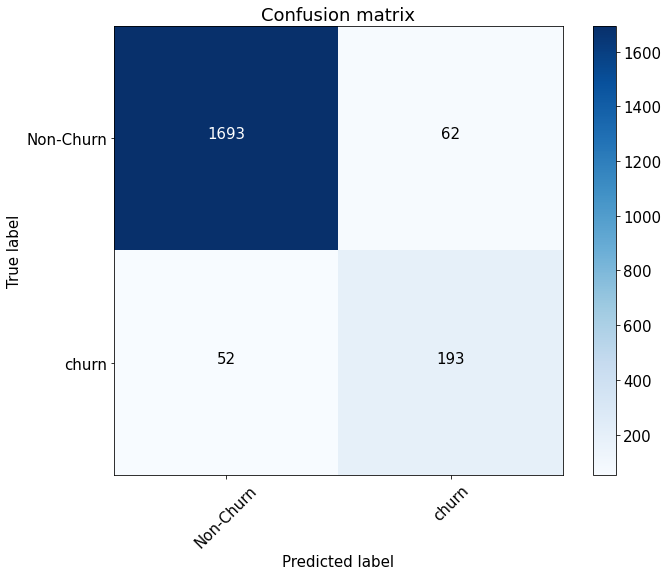

In [60]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [61]:
roc_auc_score(y_test, preds)

0.9704168847025989

Теперь попробуем применить к эмбеддингам медиану и максимальное значение.

In [63]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, f_metod=np.median), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.000000,0.091754,0.000000,0.011688,0.051833,0.000000,0.071059,...,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.025209,0.000000,0.000000
1,u108690,0.0,0.0,0.113205,0.186303,0.021463,0.000000,0.000000,0.024089,0.000000,...,0.02129,0.000000,0.00512,0.012466,0.0,0.033866,0.0,0.222218,0.000000,0.006501
2,u108339,0.0,0.0,0.087585,0.053455,0.068168,0.032506,0.010013,0.134692,0.034804,...,0.00000,0.131274,0.00000,0.000000,0.0,0.000000,0.0,0.178114,0.012046,0.018448


In [64]:
X = pd.merge(user_embeddings, target, 'left')

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [66]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.17931592, 0.00987587, 0.50585718, 0.30319821, 0.04410068,
       0.13990024, 0.0503851 , 0.03770561, 0.20593437, 0.45626113])

In [67]:
median = calc_metrics(y_test, preds)

Best Threshold=0.293681, F-Score=0.797, Precision=0.739, Recall=0.865


In [68]:
roc_auc_median = roc_auc_score(y_test, preds)
roc_auc_median

0.9772475143903715

Мы получили более хороший результат.

In [70]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, f_metod=np.max), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.122594,0.000000,0.306820,0.210206,0.134238,0.091091,0.201884,0.086887,0.438508,...,0.079069,0.234892,0.044380,0.075046,0.019207,0.327917,0.000000,0.467373,0.058234,0.117042
1,u108690,0.000000,0.035098,0.214362,0.307562,0.140047,0.015551,0.039577,0.072320,0.045131,...,0.100516,0.278312,0.043592,0.144641,0.014001,0.218968,0.027933,0.336880,0.073504,0.032221
2,u108339,0.000000,0.040035,0.161771,0.209385,0.177789,0.143322,0.038235,0.181756,0.086261,...,0.168445,0.200272,0.011631,0.019361,0.000000,0.014308,0.020224,0.256461,0.061316,0.223174


In [71]:
X = pd.merge(user_embeddings, target, 'left')

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [73]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16323882, 0.005853  , 0.92814648, 0.14555931, 0.00517811,
       0.16433014, 0.08233498, 0.16716605, 0.28850752, 0.21218016])

In [74]:
max_ = calc_metrics(y_test, preds)

Best Threshold=0.408681, F-Score=0.871, Precision=0.886, Recall=0.857


In [75]:
roc_auc_max_ = roc_auc_score(y_test, preds)
roc_auc_max_

0.9873969416826559

Этот результат оказался лучше, чем остальные.